In [60]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show

import glob
import pystac_client
import planetary_computer
import geopandas as gpd
import stackstac
import rasterio
from rasterio.merge import merge
import glob
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from rasterio import mask
from rasterio import plot
import shapely
import time
import json
import os

In [2]:
import src.height_estimation as he

In [58]:
def getFeatures(gdf): #used
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [56]:
collection="3dep-lidar-hag" 
all_tiles_dir="/hpc/group/borsuklab/ast/tiles"
tif_name = 'm_3009354_sw_15_060_20190905.tif'

catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier = planetary_computer.sign_inplace,)

#create utm geometry
#minx, miny, maxx, maxy = row[['nw_x_utm_object_coord','se_y_utm_object_coord',
#                              'se_x_utm_object_coord','nw_y_utm_object_coord']]
tank_geometry_latlon = shapely.geometry.box(-93.3446, 30.158, -93.315665, 30.186935, ccw=True) #utm
tank_geometry_utm = shapely.geometry.box(469611.99, 3339541.65, 466816.80, 3336343.38, ccw=True) #u
#search catalog using lat lon geometry
item_collection = catalog.search(collections=[collection], 
                        intersects=tank_geometry_latlon).item_collection()

In [37]:
pairs = [
    ((-900, 1), (0, 0, 0, 0)),
    ((1, 2), (205, 224, 241, 255)),
    ((2, 3), (175, 209, 231, 255)),
    ((3, 4), (137, 190, 220, 255)),
    ((4, 5), (96, 166, 210, 255)),
    ((5, 6), (34, 114, 181, 255)),
    ((6, 7), (10, 84, 158, 255)),
    ((7, 100), (8, 48, 107, 255)),
]


intervals, colors = zip(*pairs)
nodes = np.array([x[1] for x in intervals]).astype(float)
nodes -= np.abs(nodes.min())
nodes /= nodes.max()


colors = [np.asarray(c) / 255 for c in colors]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "hag", list(zip(nodes, colors))
)

In [62]:
tif_raster = rasterio.open(os.path.join(all_tiles_dir, tif_name))
geo = gpd.GeoDataFrame({'geometry': tank_geometry_utm}, index=[0], crs=tif_raster.crs)     
tif_img, tif_transform  = rasterio.mask.mask(dataset=tif_raster, shapes=getFeatures(geo), crop=True) #nodata=nodata_value, 

In [73]:
hag_raster = rasterio.open(item_collection[0].assets["data"].href)#.read().squeeze()
geo = gpd.GeoDataFrame({'geometry': tank_geometry_utm}, index=[0], crs="EPSG:26915")     
hag_img, hag_transform  = rasterio.mask.mask(dataset=hag_raster, shapes=getFeatures(geo), crop=True) #nodata=nodata_value, 

ERROR 1: Request for 6106294-6670109 failed with response_code=403
ERROR 1: Request for 7496825-8013945 failed with response_code=403
ERROR 1: Request for 8840779-9426846 failed with response_code=403
ERROR 1: Request for 10371876-10826690 failed with response_code=403
ERROR 1: Request for 6106294-6670109 failed with response_code=403
ERROR 1: Request for 7496825-8013945 failed with response_code=403
ERROR 1: Request for 8840779-9426846 failed with response_code=403
ERROR 1: Request for 10371876-10826690 failed with response_code=403


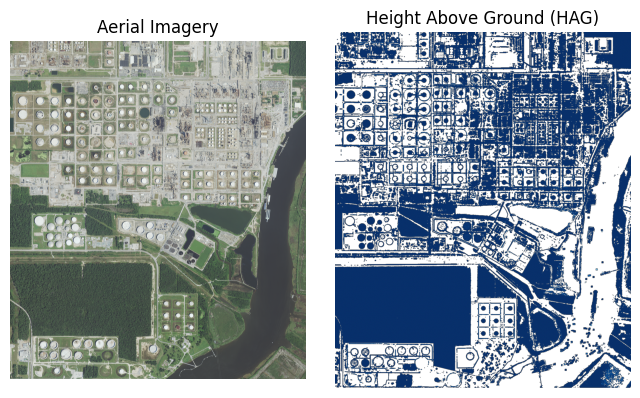

NameError: name 'filename' is not defined

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
rasterio.plot.show(tif_img[:3].squeeze(), transform=tif_transform, ax=axes[0], zorder=0) 
axes[0].set_axis_off()
axes[0].set_title(f"Aerial Imagery",fontsize=12)
axes[0].set_aspect("equal")

axes[1].imshow(cmap(hag_img.squeeze()), cmap=cmap)
axes[1].set_axis_off()
axes[1].set_title(f"Height Above Ground (HAG)",fontsize=12)
axes[1].set_aspect("equal")

plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.show()
fig.savefig(filename, dpi=600, pad_inches=1)